<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_10_3_transformer_timeseries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# T81-558: Applications of Deep Neural Networks
**Module 10: Time Series in PyTorch**  

* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Module 10 Material

* Part 10.1: Time Series Data Encoding for Deep Learning, PyTorch [[Video]](https://www.youtube.com/watch?v=CZi5Avp6p1s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_1_timeseries.ipynb)
* Part 10.2: LSTM-Based Time Series with PyTorch [[Video]](https://www.youtube.com/watch?v=hIQLy5zCgH4&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_2_lstm.ipynb)
* **Part 10.3: Transformer-Based Time Series with PyTorch** [[Video]](https://www.youtube.com/watch?v=NGzQpphf_Vc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_3_transformer_timeseries.ipynb)
* Part 10.4: Seasonality and Trend [[Video]](https://www.youtube.com/watch?v=HOkxoLaUF9s&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_4_seasonal.ipynb)
* Part 10.5: Predicting with Meta Prophet [[Video]](https://www.youtube.com/watch?v=MzjMVsz0GyA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_10_5_prophet.ipynb)

# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [103]:
# try:
#     import google.colab
#     COLAB = True
#     print("Note: using Google CoLab")
# except:
#     print("Note: not using Google CoLab")
#     COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
from tqdm import tqdm
import torch
has_mps = torch.backends.mps.is_built()
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Part 10.5: Transformers for TimeSeries in PyTorch

The transformative landscape of deep learning has witnessed monumental strides in the recent past, particularly in the domain of Natural Language Processing (NLP). Central to this revolution has been the advent of transformer architectures, which, with their attention mechanisms, have pushed the boundaries of what's achievable in tasks like machine translation, sentiment analysis, and language modeling. However, while transformers initially rose to prominence primarily within the realm of NLP, their applicability isn't restricted to just textual data. A growing wave of interest has emerged around leveraging these models for time-series predictions—a challenge that, though numerically distinct, bears conceptual resemblance to understanding sequences in language.

In time-series prediction, the objective often centers around forecasting future values based on historical data. This could involve predicting stock prices, weather patterns, or even the consumption of electricity in a region. At its core, this is a sequence-to-sequence task, where the past values form an input sequence and the future values to be predicted form an output sequence. Now, consider the similarities with machine translation in NLP, where an input sequence (sentence) in one language is translated into an output sequence in another language. Both scenarios require the model to recognize patterns, interdependencies, and context across sequences.

This chapter delves deep into the nuances of using PyTorch transformers for time-series prediction. We will embark on this journey by first establishing a foundational understanding of how transformers operate within the NLP space, before segueing into their adaptation for numeric sequences. By juxtaposing these two applications, readers will gain a comprehensive appreciation of the transformer's versatility and the subtle considerations required when transitioning from text to time.



## Loading Sun Spot Data for a Transformer Time Series

We will look at the same sunspot data as the previous section. However, this time we will use a transformer to predict. You can find the data files needed for this example at the following location.

* [Sunspot Data Files](http://www.sidc.be/silso/datafiles#total)
* [Download Daily Sunspots](http://www.sidc.be/silso/INFO/sndtotcsv.php) - 1/1/1818 to now.

We use the following code to load the sunspot file:


In [104]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

names = ['year', 'month', 'day', 'dec_year', 'sn_value',
         'sn_error', 'obs_num', 'unused1']
# df = pd.read_csv(
#     "https://data.heatonresearch.com/data/t81-558/SN_d_tot_V2.0.csv",
#     sep=';', header=None, names=names,
#     na_values=['-1'], index_col=False)
df = pd.read_csv("data.csv")

In [105]:
SEQUENCE_SIZE = 180
FORCAST = 20
FEATURE_NUM = 20
BATCH_SIZE = 256

In [106]:
df = pd.read_csv("data.csv")
df['date'] = pd.to_datetime(df['date'])
df= df[df['date'] > pd.to_datetime("2013-01-01")]

In [107]:
# DIFF_FACTOR = 10
features = df.columns.drop(labels="date")
df = df.drop(columns="date")
df["diff"] = np.concatenate(
    [
        (((df["close"][FORCAST:].values / df["close"][:-FORCAST].values)) ),
        np.zeros(FORCAST),
    ]
)

In [108]:
max_values = {}
for feature in features:
    max_val = df[feature].max()
    max_values[feature] = max_val
    df[feature] = df[feature] / max_val * 2 - 1

Just like we did for LSTM in the previous section, we again break the data into sequences.

In [109]:
# Sequence Data Preparation
def to_sequences(seq_size, obs):
    x = []
    y = []
    diff = []
    for i in range(len(obs) - seq_size - FORCAST):
        window = (
            obs[i : (i + seq_size)]
            .drop(columns=["open", "high", "close", "low", "diff"])
            .to_numpy()
        )
        # after_window = obs["close"].to_numpy()[i + seq_size + FORCAST]
        after_window = obs["close"].to_numpy()[i + seq_size + FORCAST]
        x.append(window)
        y.append(after_window)
        diff.append(obs["diff"].to_numpy()[i + seq_size])
    return (
        torch.tensor(x, dtype=torch.float32).view(-1, seq_size, FEATURE_NUM - 4),
        torch.tensor(y, dtype=torch.float32).view(-1, 1),
        torch.tensor(diff, dtype=torch.float32).view(-1, 1),
    )


train_df, test_df = df[:2400], df[2400 - SEQUENCE_SIZE :]
x_train, y_train, diff_train = to_sequences(SEQUENCE_SIZE, train_df)
x_test, y_test, diff_test = to_sequences(SEQUENCE_SIZE, test_df)

# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [110]:
extreme_factor = 0.03
train_filter = torch.logical_or(
    (diff_train - 1) > extreme_factor, (diff_train - 1) < -extreme_factor
).squeeze()

x_train_filter = x_train[train_filter]
y_train_filter = y_train[train_filter]
train_dataset_filter = TensorDataset(x_train_filter, y_train_filter)
train_loader_filter = DataLoader(
    train_dataset_filter, batch_size=BATCH_SIZE, shuffle=True
)

In [111]:
x_train_2 = x_train[x_train.shape[0] * 7 // 10 :]
y_train_2 = y_train[y_train.shape[0] * 7 // 10 :]
train_dataset_2 = TensorDataset(x_train_2, y_train_2)
train_loader_2 = DataLoader(train_dataset_2, batch_size=BATCH_SIZE, shuffle=True)

In [112]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# Constructing the Transformer Model

The following code constructs the actual transformer-based model for time series prediction. The model is constructed to accept the following parameters.

* **input_dim**: The dimension of the input data, in this case we use only one input, the number of sunspots.
* **d_model**: The number of features in the transformer model's internal representations (also the size of embeddings). This controls how much a model can remember and process.
* **nhead**: The number of attention heads in the multi-head self-attention mechanism.
* **num_layers**: The number of transformer encoder layers.
dropout: The dropout probability.



In [113]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(
        self,
        input_dim=1,
        d_model=128,
        nhead=32,
        num_layers=1,
        dropout=0.1,
        conv_kernel=3,
    ):
        super(TransformerModel, self).__init__()

        self.src_mask = None
        self.encoder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.conv = nn.Conv1d(d_model, d_model // 16, conv_kernel)
        self.decoder_1 = nn.Linear(
            (d_model // 16) * (SEQUENCE_SIZE // 3 - conv_kernel + 1), d_model
        )
        self.decoder_2 = nn.Linear(d_model, d_model // 4)
        self.decoder_3 = nn.Linear(d_model // 4, 1)

        self.relu = nn.ReLU()

    def forward(self, x):
        if self.src_mask is None or self.src_mask.size(0) != len(x):
            mask = self._generate_square_subsequent_mask(len(x)).to(device)
            self.src_mask = mask
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.relu(x)
        x = x[:, SEQUENCE_SIZE * 2 // 3 :, :]
        x = x.transpose(2, 1)
        x = self.conv(x)
        x = self.relu(x)
        # x = self.decoder_1(x[:, -1, :])
        x = x.view(x.size(0), -1)
        x = self.decoder_1(x)
        x = self.relu(x)
        x = self.decoder_2(x)
        x = self.decoder_3(x)
        return x

    def _generate_square_subsequent_mask(self, sz):
        mask = (torch.triu(torch.ones(sz, sz)) == 1).transpose(0, 1)
        mask = (
            mask.float()
            .masked_fill(mask == 0, float("-inf"))
            .masked_fill(mask == 1, float(0.0))
        )
        return mask


model = TransformerModel(input_dim=FEATURE_NUM - 4).to(device)

/home/swc/trading/venv/lib/python3.8/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [114]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
scheduler = ReduceLROnPlateau(optimizer, "min", factor=0.5, patience=3)

epochs = 180
pbar = tqdm(total=epochs)
train_losses = []
val_losses = []

for epoch in range(epochs):
    model.train()
    train_losses = []
    # loader = train_loader if epoch % 3 == 0 else train_loader_filter
    loader = train_loader if epoch < 70 else train_loader_2
    # loader = train_loader
    for batch in loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses.append(loss.item())
        optimizer.step()

    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in test_loader:
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    # scheduler.step(val_loss)
    scheduler.step(train_loss)

    pbar.set_postfix(
        {"Test Loss": f"{val_loss:.4f}", "Train Loss": f"{train_loss:.4f}"}
    )
    pbar.update(1)
    # if train_loss < .002:
    #     break

100%|██████████| 180/180 [02:45<00:00,  1.92it/s, Test Loss=0.0155, Train Loss=0.0041]

We can now evaluate the performance of this model.

In [130]:
# Evaluation
model.eval()
predictions = []
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
with torch.no_grad():
    val_losses = []
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.to(device))
        val_losses.append(loss.item())
        l = outputs.squeeze().tolist()
        if type(l) != list:
            l = [l]
        predictions.extend(l)

# rmse = np.sqrt(np.mean((scaler.inverse_transform(np.array(predictions).reshape(-1, 1)) - scaler.inverse_transform(y_test.numpy().reshape(-1, 1)))**2))
# print(f"Score (RMSE): {rmse:.4f}")

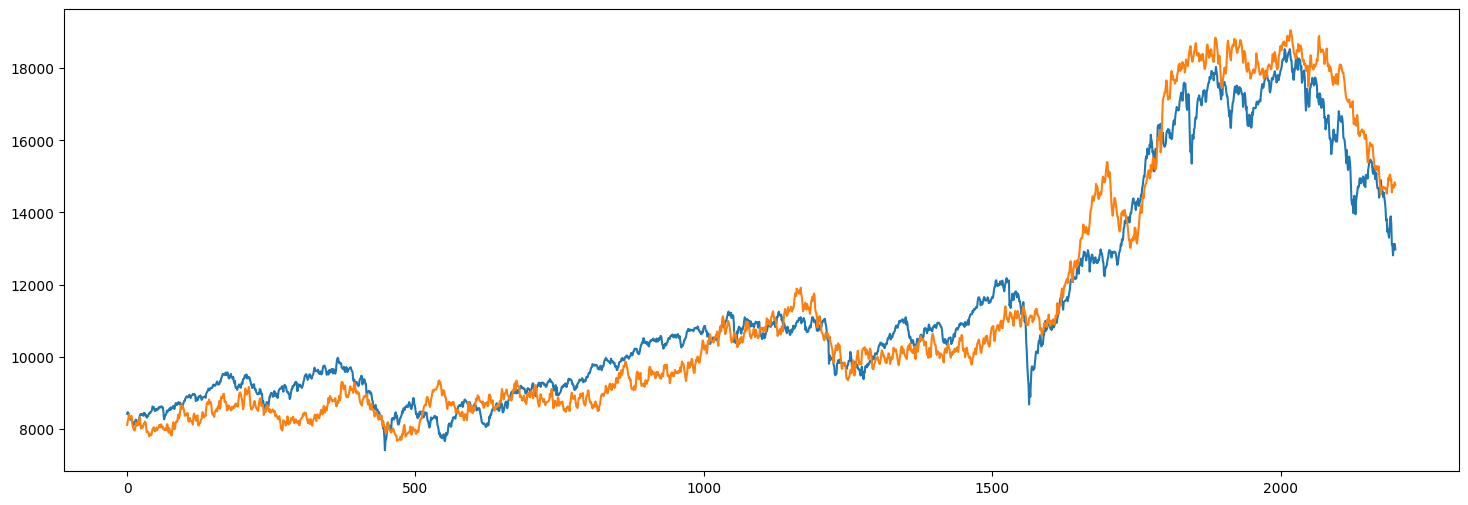

In [131]:
real_y = y_train.numpy().reshape(-1)
pred_y = np.array(predictions)
x = range(real_y.shape[0])
plt.figure(figsize=(18,6))
plt.plot(x, (real_y + 1) / 2 * max_values["close"], label = "real") 
plt.plot(x, (pred_y + 1) / 2 * max_values["close"], label = "pred") 
plt.show()

In [132]:
real = real_y
pred = pred_y

In [133]:
model.eval()
predictions = []
with torch.no_grad():
    val_losses = []
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch.to(device))
        val_losses.append(loss.item())
        l = outputs.squeeze().tolist()
        if type(l) != list:
            l = [l]
        predictions.extend(l)

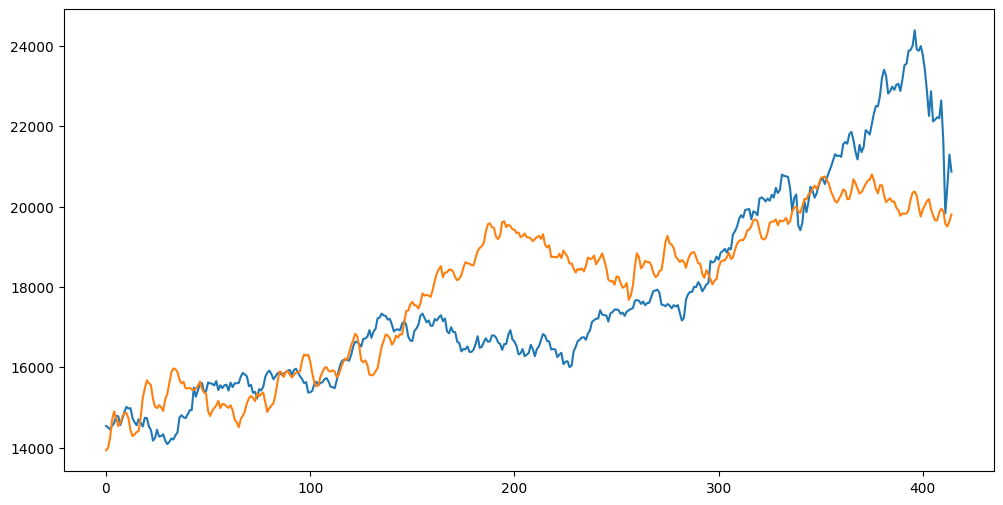

In [134]:
real_y = y_test.numpy().reshape(-1)
pred_y = np.array(predictions)
x = range(real_y.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(x, (real_y + 1) / 2 * max_values["close"], label="real")
plt.plot(x, (pred_y + 1) / 2 * max_values["close"], label="pred")
plt.show()

In [135]:
real = np.append(real,real_y)

In [145]:
real = real[500:]
pred = pred[500:]

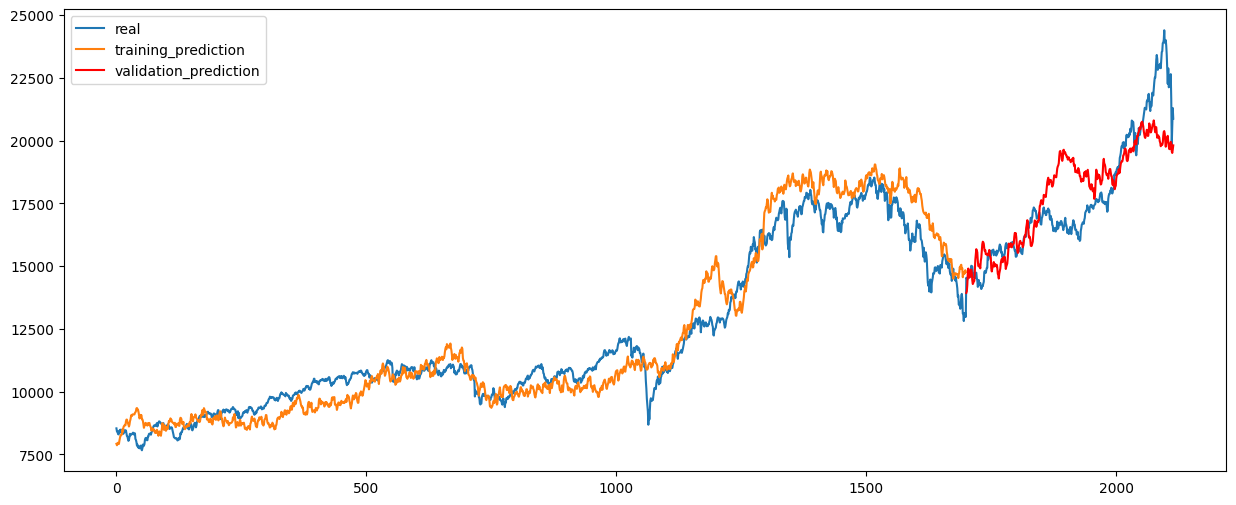

In [149]:
plt.figure(figsize=(15, 6))
plt.plot(range(real.shape[0]), (real + 1) / 2 * max_values["close"], label="real")
plt.plot(
    range(pred.shape[0]), (pred + 1) / 2 * max_values["close"], label="training_prediction"
)
plt.plot(
    range(pred.shape[0], pred.shape[0] + pred_y.shape[0]),
    (pred_y + 1) / 2 * max_values["close"],
    "r",
    label="validation_prediction",
)
plt.legend()
plt.show()

In [18]:
x = []
for i in range(len(df) - SEQUENCE_SIZE):
    window = (
        df[i : (i + SEQUENCE_SIZE)]
        .drop(columns=["open", "high", "close", "low", "diff"])
        .to_numpy()
    )
    x.append(window)
x = torch.tensor(x, dtype=torch.float32).view(-1, SEQUENCE_SIZE, FEATURE_NUM - 4)

In [19]:
x = x[-(50 + FORCAST):]
model.eval()
predictions = []
with torch.no_grad():
    val_losses = []
    x_batch = x.to(device)
    outputs = model(x_batch)
    l = outputs.squeeze().tolist()
    predictions.extend(l)

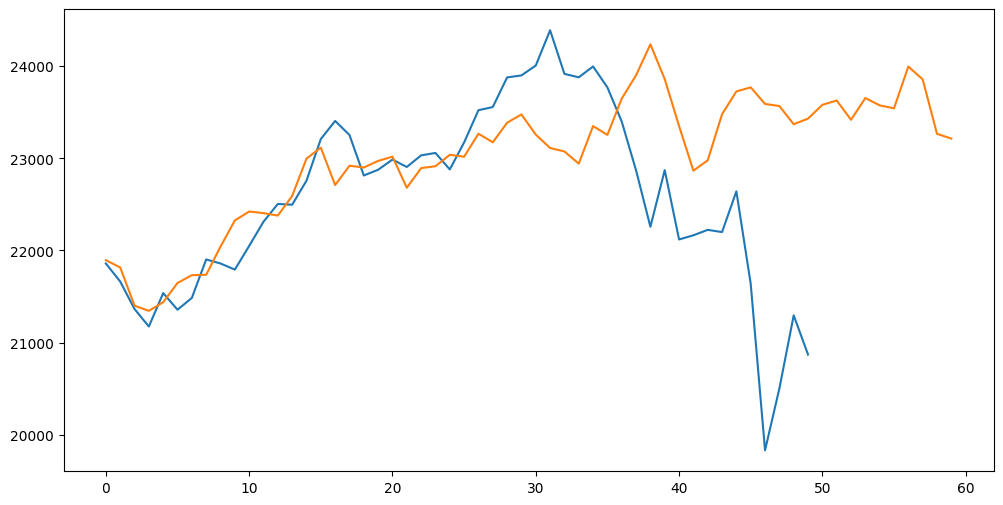

In [20]:
pred_y = np.array(predictions)
real_y = y_test.numpy().reshape(-1)
x = range(pred_y.shape[0])
plt.figure(figsize=(12, 6))
plt.plot(range(50), (real_y[-50:] + 1) / 2 * max_values["close"], label="real")
plt.plot(x, (pred_y + 1) / 2 * max_values["close"], label="pred")
plt.show()